## Import Libraries

In [2]:
import os
import cv2
import numpy as np
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import albumentations as A
from PIL import Image   

c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Import Env File

In [3]:
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('DATASET_PATH')
models_path = os.getenv('MODELS_PATH')

## Device Configuration

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Hyperparameters

In [6]:
num_classes = 2  
batch_size = 16
test_split_ratio = 0.2
val_split_ratio = 0.2
image_size = (224, 224)

## Data Preprocessing

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [29]:
augment = A.Compose([
    A.HorizontalFlip(p=0.8),
    A.RandomBrightnessContrast(p=0.6),
    A.Rotate(limit=15, p=0.7),
    A.Affine(scale=(0.95, 1.05), translate_percent=(0.05, 0.05), rotate=15, p=0.6)  
])
num_augmentations_per_image = 4

In [30]:
all_images = []
all_labels = []

for class_idx, class_name in enumerate(os.listdir(datasets_path)):
    class_folder = os.path.join(datasets_path, class_name)
    if not os.path.isdir(class_folder):
        continue

    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)

        # Original image
        pil_img = Image.fromarray(image)
        tensor = transform(pil_img)
        all_images.append(tensor)
        all_labels.append(class_idx)

        # Augmented images
        for _ in range(num_augmentations_per_image):
            augmented = augment(image=image)
            aug_img = augmented['image']
            aug_pil = Image.fromarray(aug_img)
            tensor_aug = transform(aug_pil)
            all_images.append(tensor_aug)
            all_labels.append(class_idx)


## Data Loaders

In [31]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

# Convert to tensors
X = torch.stack(all_images)
y = torch.tensor(all_labels)

# Step 1: Split awal jadi train_val dan test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=test_split_ratio, stratify=y, random_state=42
)

# Step 2: Split train_val jadi train dan validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_split_ratio, stratify=y_train_val, random_state=42
)

# Step 3: Buat DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [32]:
print(f"Total samples after augmentation: {len(all_images)}")
print(f"Train size: {len(train_loader.dataset)}, Test size: {len(test_loader.dataset)}, Val size: {len(val_loader.dataset)}")

Total samples after augmentation: 960
Train size: 614, Test size: 192, Val size: 154


In [33]:
from collections import Counter
print(f"Jumlah kelas unik di y: {len(torch.unique(y))}")
print("Distribusi label:", Counter(y.tolist()))
print(f"Bentuk tensor X (jumlah gambar, channel, tinggi, lebar): {X.shape}")

Jumlah kelas unik di y: 2
Distribusi label: Counter({0: 480, 1: 480})
Bentuk tensor X (jumlah gambar, channel, tinggi, lebar): torch.Size([960, 3, 224, 224])


## load Pre-Trained Model

In [34]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class EfficientNetCustom(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetCustom, self).__init__()

        # Definisikan weights sebelum digunakan
        weights = EfficientNet_B0_Weights.DEFAULT
        self.model = efficientnet_b0(weights=weights)

        # Ambil fitur backbone dan avgpool dari model
        self.features = self.model.features
        self.avgpool = self.model.avgpool
        self.dropout = nn.Dropout(0.3)

        # Ambil jumlah fitur input classifier dari model asli
        in_features = self.model.classifier[1].in_features

        # Buat classifier custom
        self.fc1 = nn.Linear(in_features, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## Train The Model

In [35]:
# Loss and optimizer
model = EfficientNetCustom(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.5, patience=2, verbose=True)

# Inisialisasi early stopping
best_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 5
num_epochs = 60

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    val_acc = evaluate(model, test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}')

    scheduler.step(epoch_loss)

    if epoch_loss < best_loss - 1e-4:
        best_loss = epoch_loss
        epochs_no_improve = 0
        torch.save(model, 'best_model_cnn.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"⛔ Early stopping triggered at epoch {epoch+1}")
        break


c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/60], Loss: 0.6732, Val Acc: 0.8125
Epoch [2/60], Loss: 0.5927, Val Acc: 0.8958
Epoch [3/60], Loss: 0.4838, Val Acc: 0.9219
Epoch [4/60], Loss: 0.3657, Val Acc: 0.9167
Epoch [5/60], Loss: 0.2728, Val Acc: 0.9323
Epoch [6/60], Loss: 0.1938, Val Acc: 0.9427
Epoch [7/60], Loss: 0.1272, Val Acc: 0.9375
Epoch [8/60], Loss: 0.1234, Val Acc: 0.9479
Epoch [9/60], Loss: 0.0925, Val Acc: 0.9635
Epoch [10/60], Loss: 0.0801, Val Acc: 0.9635
Epoch [11/60], Loss: 0.0813, Val Acc: 0.9688
Epoch [12/60], Loss: 0.0569, Val Acc: 0.9688
Epoch [13/60], Loss: 0.0610, Val Acc: 0.9635
Epoch [14/60], Loss: 0.0443, Val Acc: 0.9740
Epoch [15/60], Loss: 0.0410, Val Acc: 0.9792
Epoch [16/60], Loss: 0.0311, Val Acc: 0.9740
Epoch [17/60], Loss: 0.0251, Val Acc: 0.9740
Epoch [18/60], Loss: 0.0480, Val Acc: 0.9792
Epoch [19/60], Loss: 0.0236, Val Acc: 0.9688
Epoch [20/60], Loss: 0.0380, Val Acc: 0.9792
Epoch [21/60], Loss: 0.0278, Val Acc: 0.9792
Epoch [22/60], Loss: 0.0290, Val Acc: 0.9740
Epoch [23/60], Loss

## Evaluation

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluasi klasifikasi
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9792    0.9792    0.9792        96
           1     0.9792    0.9792    0.9792        96

    accuracy                         0.9792       192
   macro avg     0.9792    0.9792    0.9792       192
weighted avg     0.9792    0.9792    0.9792       192



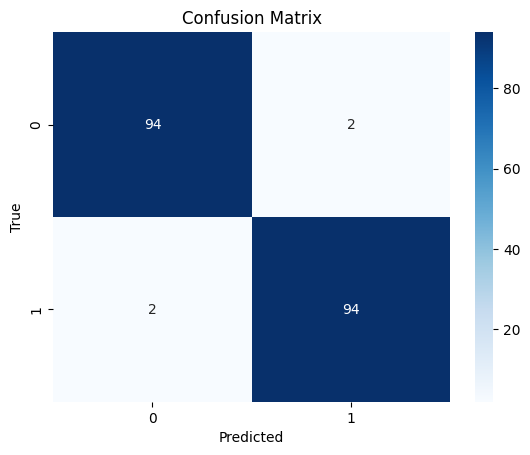

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Save The Model

In [38]:
torch.save(model.state_dict(), models_path+'/CNN2.pth')